# Dynamic Pricing Model Analysis for Eintracht Frankfurt

## Introduction
This notebook presents an analysis of a dynamic pricing model for Eintracht Frankfurt, inspired by the scientific paper *"Designing a Dynamic Pricing Model for Bayern Munich"* by Christoph Kemper and Christoph Breuer.

### Objective
The objective of this research is to:
- Analyze ticket demand and pricing trends.
- Evaluate the efficiency of a dynamic pricing approach.
- Compare results to fixed pricing models.

This analysis follows a structured approach using real-world data and visualizations to validate the findings.


In [ ]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import os
# from scipy.optimize import fsolve

## Data Loading and Preparation
Before conducting any analysis, we load the dataset and perform necessary preprocessing steps such as:
- Handling missing values.
- Converting data types where needed.
- Exploring the dataset to understand its structure.

A summary of the dataset is provided below:


In [3]:

# Load the Excel file
file_path = "primary_market_data.xlsx"  # Update with the correct path if needed
xls = pd.ExcelFile(file_path)

# Load the sheet into a DataFrame
df = pd.read_excel(xls, sheet_name="Saisonübersicht")

# Filter for Bundesliga 23/24 and 24/25 seasons
filtered_df = df[df["Competition"].isin(["Bundesliga 2023/24", "Bundesliga 2024/25"])]
# Keep only relevant price categories
valid_categories = {"Kat. 1": "1", "Kat. 2": "2", "Kat. 3": "3", "Kat. 4": "4", "Stehplatz": "_st"}
filtered_df = filtered_df[filtered_df["Price Category"].isin(valid_categories.keys())]

# Extract opponent team from EventName
filtered_df["Opponent"] = filtered_df["EventName"].str.split(" vs. ").str[1]

top_12_teams = [
    "FC Bayern München", "Borussia Dortmund", "RB Leipzig", "Bayer 04 Leverkusen",
    "VfB Stuttgart", "Eintracht Frankfurt", "SC Freiburg", "TSG Hoffenheim",
    "SV Werder Bremen", "Borussia Mönchengladbach", "VfL Wolfsburg", "1. FSV Mainz 05"
]


# Normalize team names for better matching
def classify_opponent(opponent):
    if any(team.lower() in str(opponent).lower() for team in top_12_teams):
        return "A"
    return "B"

# Categorize opponents into 'Cool' and 'Not Cool'
filtered_df["Opponent Category"] = filtered_df["Opponent"].apply(classify_opponent)

# Convert 'Date' and 'Kick-off Time' into a single datetime column
filtered_df["Match DateTime"] = pd.to_datetime(
    filtered_df["Date"].astype(str) + " " + filtered_df["Kick-off Time"].astype(str)
)



# Determine if the match is on a weekend
filtered_df["Is Weekend"] = filtered_df["Match DateTime"].dt.weekday >= 5  # Saturday (5) & Sunday (6)

# Extract match start hour
filtered_df["Match Start Hour"] = filtered_df["Match DateTime"].dt.hour

# Create new category name (A1, A2, ..., B4)
def create_category(price_category, opponent_category):
    number = valid_categories.get(price_category, "Unknown")
    return f"{opponent_category}{number}"

filtered_df["Category"] = filtered_df.apply(lambda row: create_category(row["Price Category"], row["Opponent Category"]), axis=1)

# Select relevant columns
final_df = filtered_df[["Competition", "EventId", "Category", "Opponent", "Opponent Category", "Price Category", "Booked Tickets", "AVG Price", "Match DateTime", "Is Weekend", "Match Start Hour"]]


# Display the first few rows
# print(final_df.head())


In [4]:
final_df

,Competition,EventId,Category,Opponent,Opponent Category,Price Category,Booked Tickets,AVG Price,Match DateTime,Is Weekend,Match Start Hour
250,Bundesliga 2023/24,6454ed7f5cbf087f5040b053,B1,SV Darmstadt 98,B,Kat. 1,6929,43.728070,2023-08-20 17:30:00,True,17
251,Bundesliga 2023/24,6454ed7f5cbf087f5040b053,B2,SV Darmstadt 98,B,Kat. 2,6819,36.374987,2023-08-20 17:30:00,True,17
252,Bundesliga 2023/24,6454ed7f5cbf087f5040b053,B3,SV Darmstadt 98,B,Kat. 3,8297,32.327871,2023-08-20 17:30:00,True,17
253,Bundesliga 2023/24,6454ed7f5cbf087f5040b053,B4,SV Darmstadt 98,B,Kat. 4,8995,28.865415,2023-08-20 17:30:00,True,17
256,Bundesliga 2023/24,6454ed7f5cbf087f5040b053,B_st,SV Darmstadt 98,B,Stehplatz,15843,7.662873,2023-08-20 17:30:00,True,17
...,...,...,...,...,...,...,...,...,...,...,...
587,Bundesliga 2024/25,661692d89873f8097678c5ac,B1,FC St. Pauli,B,Kat. 1,6467,48.370248,2025-05-10 15:30:00,True,15
588,Bundesliga 2024/25,661692d89873f8097678c5ac,B2,FC St. Pauli,B,Kat. 2,6643,37.191134,2025-05-10 15:30:00,True,15
589,Bundesliga 2024/25,661692d89873f8097678c5ac,B3,FC St. Pauli,B,Kat. 3,6783,30.249353,2025-05-10 15:30:00,True,15
590,Bundesliga 2024/25,661692d89873f8097678c5ac,B4,FC St. Pauli,B,Kat. 4,6588,26.015925,2025-05-10 15:30:00,True,15


In [5]:
# final_df[final_df["Opponent Category"] == "A"]

In [6]:
# Weighted average price calculation based on seat numbers
# For price by weekend
avg_price_weekend = final_df.groupby("Is Weekend").apply(
    lambda x: (x["AVG Price"] * x["Booked Tickets"]).sum() / x["Booked Tickets"].sum()).reset_index(name="Weighted AVG Price")

# For price by match start hour
avg_price_by_hour = final_df.groupby("Match Start Hour").apply(
    lambda x: (x["AVG Price"] * x["Booked Tickets"]).sum() / x["Booked Tickets"].sum()).reset_index(name="Weighted AVG Price")

# Display the results
print("\nPrice differentiation between weekends and weekdays (weighted):")
print(avg_price_weekend.head())

print("\nPrice differentiation based on match start time (weighted):")
print(avg_price_by_hour)


Price differentiation between weekends and weekdays (weighted):
   Is Weekend  Weighted AVG Price
0       False           28.174013
1        True           26.607805

Price differentiation based on match start time (weighted):
   Match Start Hour  Weighted AVG Price
0                15           26.326552
1                17           26.450127
2                18           28.312886
3                19           23.421903
4                20           28.174013


C:\Users\User\AppData\Local\Temp\ipykernel_10164\2768169088.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_price_weekend = final_df.groupby("Is Weekend").apply(
C:\Users\User\AppData\Local\Temp\ipykernel_10164\2768169088.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_price_by_hour = final_df.groupby("Match Start Hour").apply(


## Analysis of Match Timing and Opponent Strength

### Initial Hypothesis
Our initial assumption was:
- Matches on weekends would have **higher ticket prices** due to increased demand.
- Matches during peak hours (rush hour) would also be **more expensive**.

### Findings
However, the data analysis showed that **match timing (weekend vs. weekday, rush hour vs. non-rush hour) does not significantly impact ticket prices**. The key factors influencing ticket prices were:

1. **Opponent Quality** – Matches against stronger opponents had higher ticket prices.
2. **Seat Type** – Premium seating areas were consistently more expensive.

### Further Analysis
Given these findings, we conducted a deeper analysis by segmenting the data into:
- **Seat Categories** (different types of *Sitzplatz*).
- **Opponent Strength**:
  - **Top 12 Teams**: Clubs ranked in the top 12 of the league.
  - **Bottom Teams**: Clubs in the lower half of the table.

The results confirmed that **ticket prices are primarily driven by opponent quality and seating category** rather than the match timing. This insight suggests that fans are willing to pay more based on the perceived importance of the match rather than convenience factors like weekends or rush hour.


In [7]:
# For average price per category (considering seat numbers)
avg_price_per_category = final_df.groupby(["Competition", "Opponent Category", "Price Category"]).apply(
    lambda x: (x["AVG Price"] * x["Booked Tickets"]).sum() / x["Booked Tickets"].sum()).reset_index(name="Weighted AVG Price")

# Display the first few rows of the aggregated data
print("\nAverage price per category (weighted):")
print(avg_price_per_category)


Average price per category (weighted):
           Competition Opponent Category Price Category  Weighted AVG Price
0   Bundesliga 2023/24                 A         Kat. 1           45.258173
1   Bundesliga 2023/24                 A         Kat. 2           38.069516
2   Bundesliga 2023/24                 A         Kat. 3           34.318919
3   Bundesliga 2023/24                 A         Kat. 4           30.419558
4   Bundesliga 2023/24                 A      Stehplatz            9.320391
5   Bundesliga 2023/24                 B         Kat. 1           42.937852
6   Bundesliga 2023/24                 B         Kat. 2           36.263691
7   Bundesliga 2023/24                 B         Kat. 3           31.661685
8   Bundesliga 2023/24                 B         Kat. 4           28.325560
9   Bundesliga 2023/24                 B      Stehplatz            8.718138
10  Bundesliga 2024/25                 A         Kat. 1           52.690158
11  Bundesliga 2024/25                 A        

C:\Users\User\AppData\Local\Temp\ipykernel_10164\2620469478.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_price_per_category = final_df.groupby(["Competition", "Opponent Category", "Price Category"]).apply(


## Demand Function and Willingness to Pay

### Introduction to the Demand Function
The **demand function** describes an individual's **willingness to pay** for a ticket. It follows these principles:
- **At price = 0**, willingness to pay is **1** (everyone is willing to take a free ticket).
- **As price increases**, willingness to pay **gradually decreases**.
- **At an unacceptably high price**, willingness to pay approaches **0**.

### Challenges in Defining Willingness to Pay
Estimating true willingness to pay is difficult because:
- Fans may **report lower values** when surveyed to keep prices low.
- Real-world ticket sales may be **influenced by artificial price caps** set by the club.

### Using eBay Auction Data
To determine a **realistic** willingness to pay, we used **eBay auction data** instead of official ticket sales data. Auctions reflect **true market demand** because:
- Buyers **compete** by bidding, revealing their **actual** willingness to pay.
- Prices fluctuate naturally based on **real demand and match importance**.
- No artificial price restrictions exist, making it a **pure price discovery process**.

This approach provides a **more accurate** estimation of the demand function, allowing us to model optimal ticket pricing based on real consumer behavior.


This is how the model is expected to behave in a **theoretical** scenario.  

### Scientific Approach: Reproducing the Paper  
Initially, our goal was to **replicate the scientific paper** on dynamic pricing. To do this:  
- We took the **same demand functions** used in the study.  
- We **synthesized data** based on these functions to test the pricing model. The accept-reject Monte-Carlo method was used 
- This allowed us to compare our results with the **original research findings**.  

After validating the results against the research paper:
- We reconstructed a demand function that resembled the original study.
- This ensures that the pricing model behaves similarly to what was reported in the paper. 

Here is a demand function formula and the probability density function which is no more but the derivative

In [8]:

# Define demand function based on extracted coefficients
def demand_function(price, a, b, c):
    return 1 / ((1 / a) + b * (c ** price))

# Define the derivative (PDF) of the demand function
def demand_pdf(price, a, b, c):
    numerator = b * (c ** price) * np.log(c)
    denominator = ((1 / a) + b * (c ** price)) ** 2
    return numerator / denominator

Here we try to find the coefficients for demand function trying to keep same structure as in the scientific article

In [ ]:
# Points where the demand function reaches 50%. Taken as a % of average an average first market price
article_shirts = {
    "A1": 1.04,
    "A2": 0.87,
    "A3": 0.78,
    "A4": 0.51,
    "B1": 1.17,
    "B2": 0.96,
    "B3": 0.75,
    "B4": 0.84,
}

Reconstruction function. Uncomment to have different results. Ensure that none of the coefs is negative

In [ ]:

# # Initialize the coefficients dictionary
# demand_coeffs = {}

# # Initialize the coefficients dictionary
# demand_coeffs = {}

# for category in article_shirts.keys():
#     # Extract avg price
#     avg = np.mean(final_df[final_df["Category"] == category]["AVG Price"].values)

#     # Compute z
#     z = avg * (1 + article_shirts[category])

#     # Generate a random value for a within a reasonable range
#     a = np.random.uniform(0.9, 1.9)

#     def equations(vars):
#         b, c = vars  # Now solving only for b and c
        
#         # Condition 1: f(z) = 0.5
#         eq1 = 1 / ((1 / a) + (b * (c ** z))) - 0.5

#         # Condition 2: f(avg) = random(0.90, 0.99)
#         rand_value = np.random.uniform(0.97, 0.99)
#         eq2 = 1 / ((1 / a) + (b * (c ** avg))) - rand_value

#         return [eq1, eq2]

#     # Initial guesses for b and c
#     initial_guesses = [1 - 1/a, 1.0]

#     # Solve for b and c
#     b_solution, c_solution = fsolve(equations, initial_guesses)

#     # Store the coefficients in the dictionary
#     demand_coeffs[category] = (round(a, 3), round(b_solution, 3), round(c_solution, 3))

# # Print the final dictionary
# print("demand_coeffs = {")
# for key, value in demand_coeffs.items():
#     print(f'    "{key}": {value},')
# print("}")



Coefficients that describe our data. Used to do a Monte-Carlo simulation

In [ ]:
demand_coeffs = {
    "A1": (1.628, 0.395, 1.013),
    "A2": (1.152, 0.132, 1.026),
    "A3": (1.362, 0.267, 1.025),
    "A4": (1.765, 0.376, 1.028),
    "B1": (1.592, 0.365, 1.014),
    "B2": (1.477, 0.32, 1.02),
    "B3": (1.381, 0.268, 1.029),
    "B4": (1.826, 0.442, 1.023),
}

Coefficient taken from original paper. Used to check if the simulation is correct

In [ ]:
# # Coefficients from the extracted image data
# demand_coeffs = {
#     "A1": (1.513, 0.136, 1.015),
#     "A2": (1.075, 0.009, 1.038),
#     "A3": (0.959, 0.013, 1.038),
#     "A4": (1.558, 0.294, 1.023),
#     "B1": (1.017, 0.013, 1.034),
#     "B2": (1.416, 0.071, 1.031),
#     "B3": (1.2, 0.015, 1.027),  # Adjusted to logistic model instead of exponential
#     "B4": (0.995, 0.005, 1.055),
# }

In [12]:
# Generate secondary market data
np.random.seed(42)  # For reproducibility
secondary_market_data = []
num_samples_per_category = {"A1": 45, "A2": 66, "A3": 58, "A4": 86, "B1": 59, "B2": 58, "B3": 74, "B4": 66}
event_ids_by_category = final_df.groupby("Category")["EventId"].apply(list).to_dict()

for category, (a, b, c) in demand_coeffs.items():
    primary_prices = final_df[final_df["Category"] == category]["AVG Price"].values
    if len(primary_prices) == 0:
        continue
    
    avg_primary_price = np.mean(primary_prices)
    max_price = 500  # Assume max price is 2x primary price
    
    accepted_prices = []
    num_samples = num_samples_per_category.get(category, 500)  # Number of desired samples per category
    
    while len(accepted_prices) < num_samples:
        proposal_price = np.random.uniform(17, max_price)  # Proposal price from uniform distribution
        acceptance_prob = demand_pdf(proposal_price, a, b, c)
        if np.random.uniform(0, 1) < acceptance_prob:
            accepted_prices.append(proposal_price)
    
    for price in accepted_prices:
        event_id = np.random.choice(event_ids_by_category.get(category, [None]))
        secondary_market_data.append([event_id, category, price])

# Create DataFrame
secondary_market_df = pd.DataFrame(secondary_market_data, columns=["EventID", "Category", "Price"])

# Display first few rows of generated data
print(secondary_market_df)


# # File name
# file_name = "secondary_market.xlsx"

# # Check if file exists
# if not os.path.exists(file_name):
#     secondary_market_df.to_excel(file_name, index=False)
#     print(f"File '{file_name}' has been saved.")
# else:
#     print(f"File '{file_name}' already exists.")

                      EventID Category       Price
0    661691791b5f5911a30008ba       A1  128.291248
1    6454eea36d644d4eb741244c       A1   96.832409
2    661692583ef1c31fc165c9fb       A1  159.883039
3    66168eae6093890d4d4bbd54       A1   74.099595
4    661692583ef1c31fc165c9fb       A1   54.074144
..                        ...      ...         ...
507  661692020f191b563f2a6290       B4   25.470303
508  6454ef7864ace50d2b5609de       B4   23.461227
509  661692b4cccaed2aaf458c83       B4  100.169046
510  661692b4cccaed2aaf458c83       B4   22.996410
511  66168f6d4f931c05a544ab88       B4  154.198108

[512 rows x 3 columns]


## Exploratory Data Analysis
We start by visualizing key trends in the data, such as:
- Distribution of ticket prices.
- Demand for tickets across different seating categories.
- Correlation between ticket price and seat location.

Below are some key visualizations:
1. **Histogram of Ticket Prices:** Shows the distribution of ticket prices.
2. **Price vs. Demand Curve:** Helps understand the relationship between price and ticket sales.

These insights provide a foundation for building the dynamic pricing model.


<Figure size 1200x800 with 0 Axes>

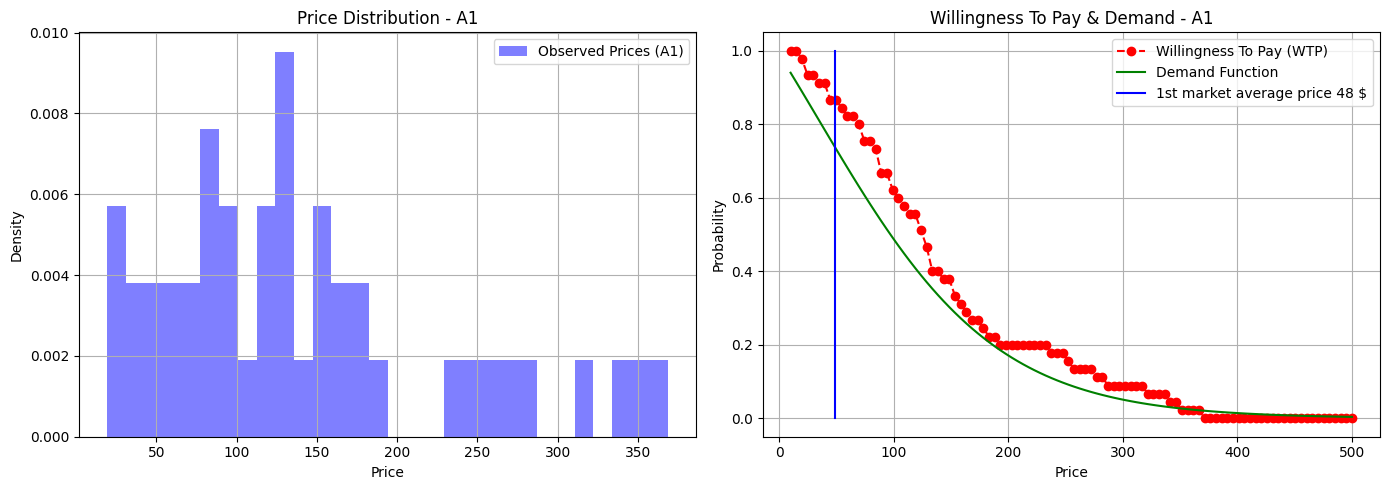

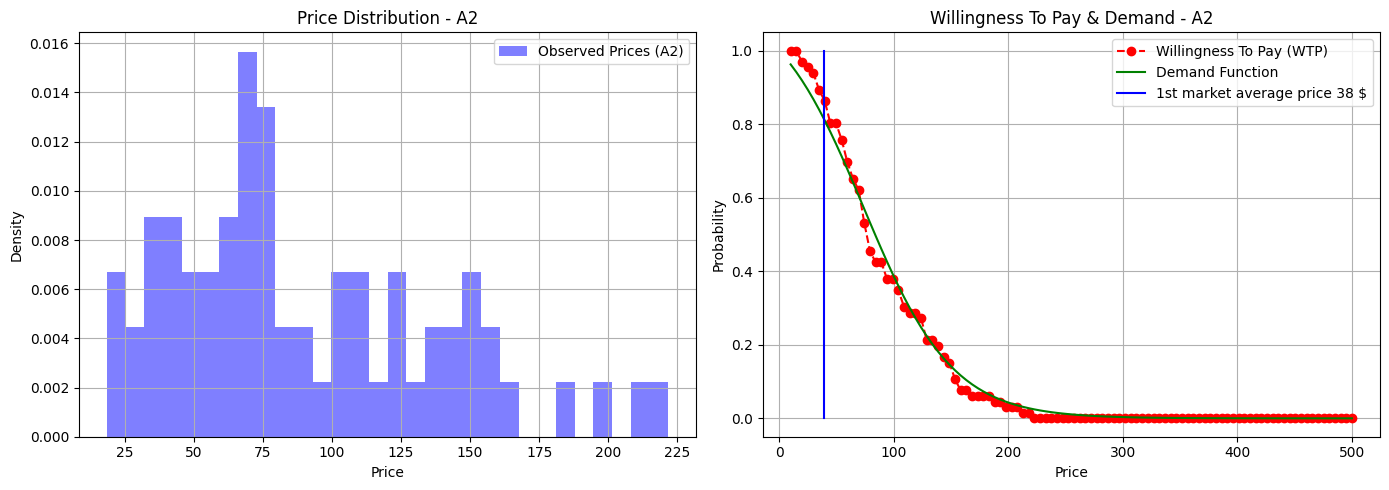

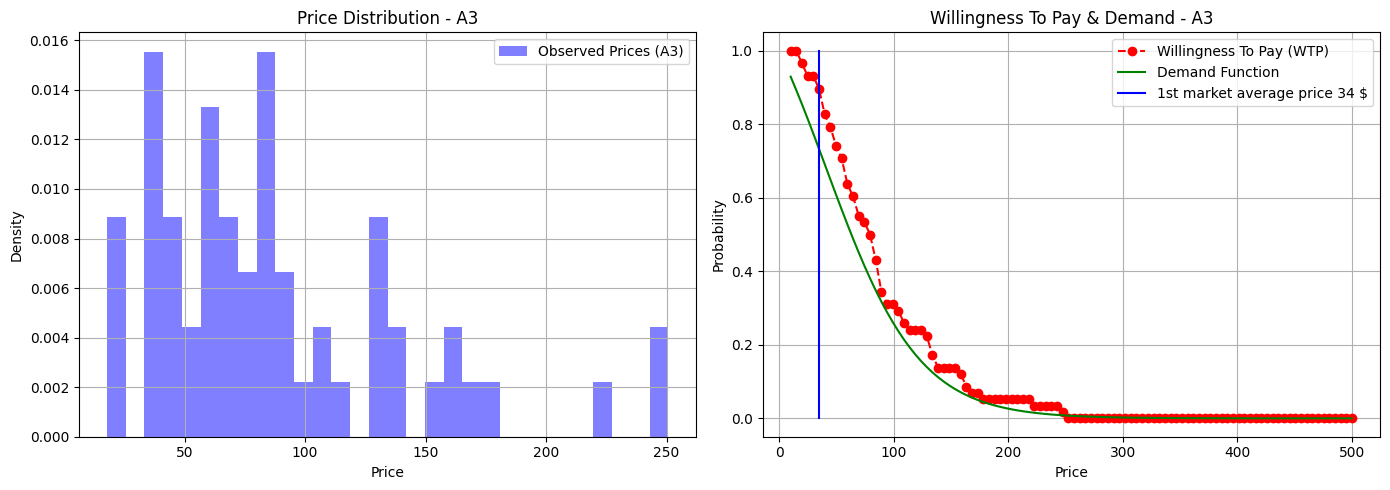

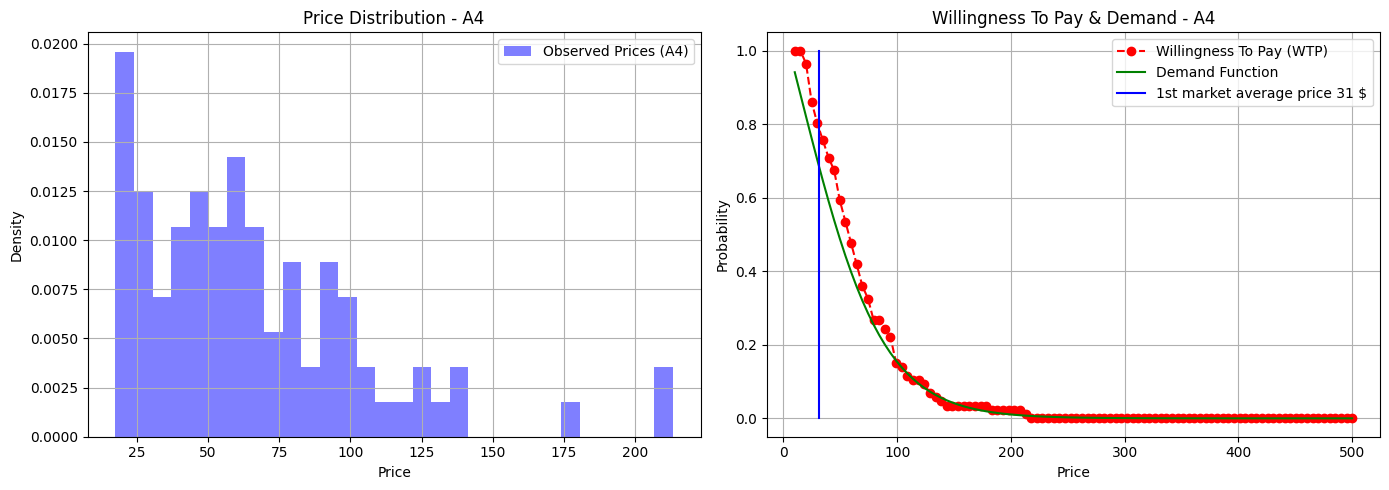

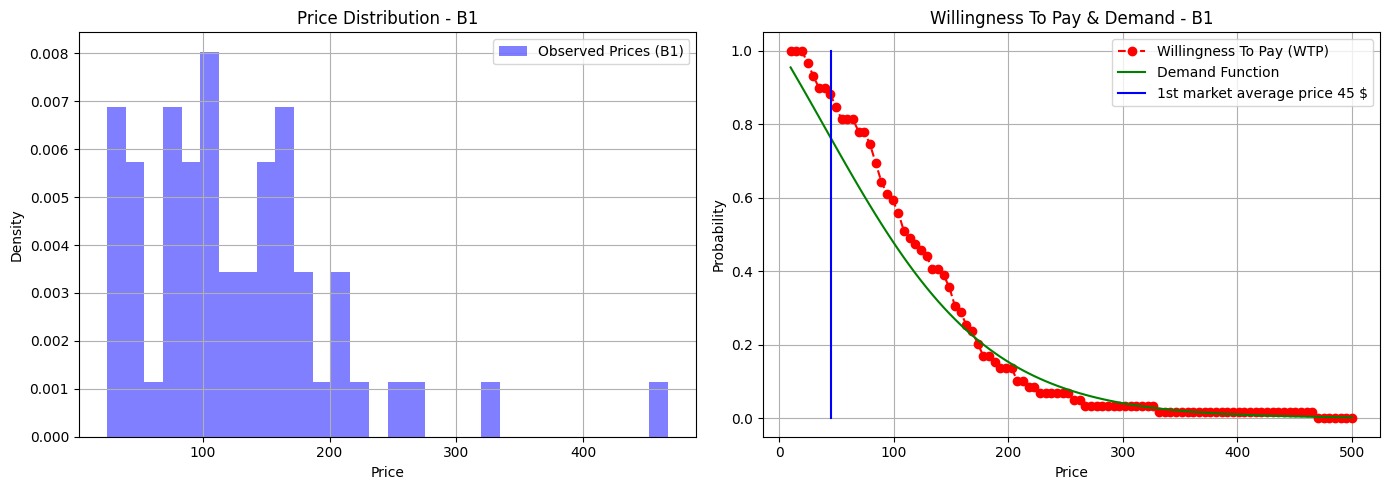

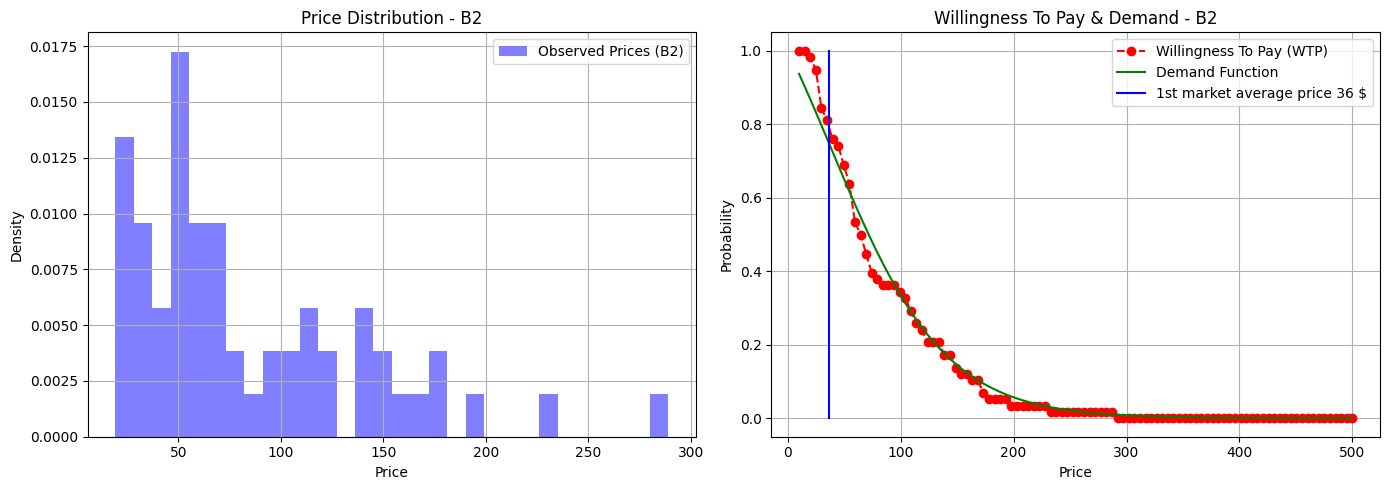

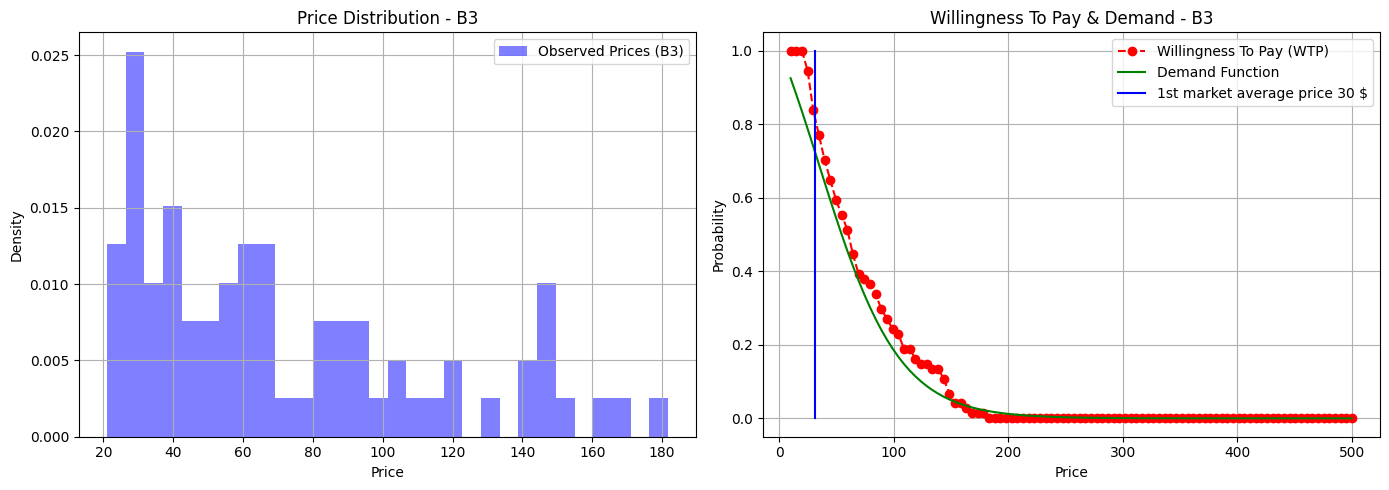

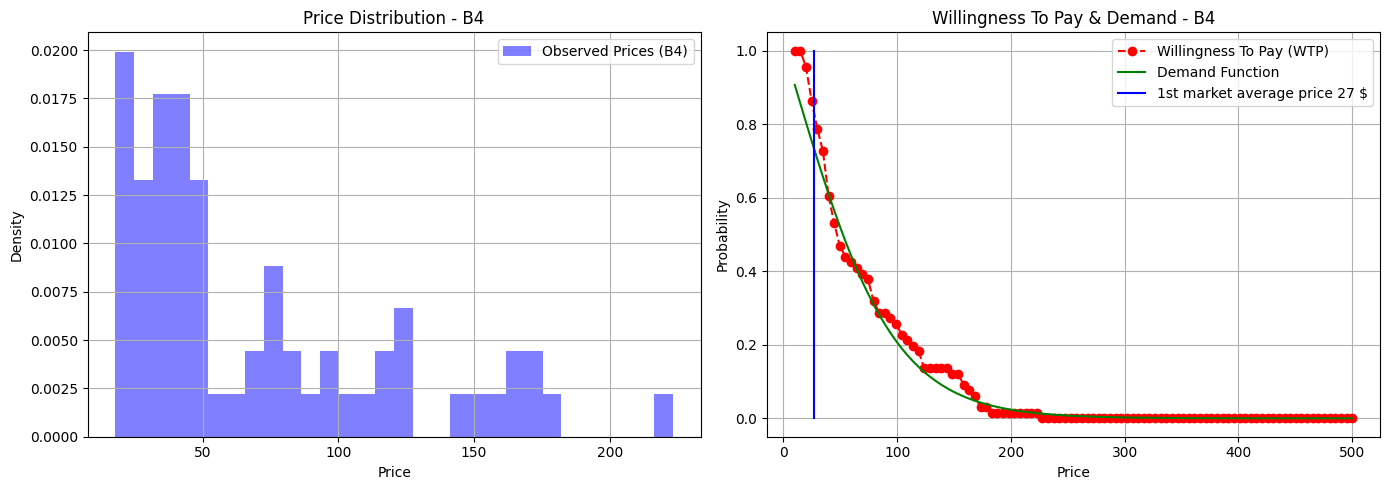

In [13]:
# Plot price distribution for each category
plt.figure(figsize=(12, 8))

categories = secondary_market_df["Category"].unique()

for category in categories:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Two subplots side by side
    
    avg = np.mean(final_df[final_df["Category"] == category]["AVG Price"].values)
    # Extract secondary market prices for the category
    prices = secondary_market_df[secondary_market_df["Category"] == category]["Price"].values

    # Generate price thresholds
    price_thresholds = np.linspace(10, 500, 100)

    # Compute WTP values (probability of paying more than threshold)
    wtp_values = [np.mean(prices > p) for p in price_thresholds]

    # Extract demand coefficients
    a, b, c = demand_coeffs[category]

    # Compute demand function values
    demand_values = [demand_function(p, a, b, c) for p in price_thresholds]

    # --- First subplot: Histogram of observed prices ---
    axes[0].hist(prices, bins=30, alpha=0.5, density=True, color="blue", label=f"Observed Prices ({category})")
    axes[0].set_xlabel("Price")
    axes[0].set_ylabel("Density")
    axes[0].set_title(f"Price Distribution - {category}")
    axes[0].legend()
    axes[0].grid()

    # --- Second subplot: WTP Curve & Demand Function ---
    axes[1].plot(price_thresholds, wtp_values, color="red", marker="o", linestyle="--", label="Willingness To Pay (WTP)")
    axes[1].plot(price_thresholds, demand_values, color="green", linestyle="-", label="Demand Function")
    axes[1].plot([avg,avg], [0,1], color="blue", linestyle="-", label=f"1st market average price {int(avg)} $")
    axes[1].set_xlabel("Price")
    axes[1].set_ylabel("Probability")
    axes[1].set_title(f"Willingness To Pay & Demand - {category}")
    axes[1].legend()
    axes[1].grid()

    # Show plots
    plt.tight_layout()
    plt.show()

## Bellman’s Equation and Dynamic Pricing Model  

### Theoretical Foundation  
To optimize ticket pricing, we use a **dynamic pricing model** based on **Bellman’s Equation**. This model, derived from the **Bernoulli dynamic pricing approach**, assumes:  
- A **monopolist** (e.g., Eintracht Frankfurt) sells a **fixed number of tickets ($C$)** over a **limited time period ($T$)**.  
- Each period **$t$**, only **one customer** arrives, wanting to buy **one ticket**.  
- At each time step, the **seller sets a price ($p_t$)**, and the customer purchases if **their willingness to pay $\geq p_t$**.  
- If the selling period ends, **unsold tickets lose all value** (e.g., match day passes).  

### Bellman’s Recursive Equation  
The revenue-maximizing pricing strategy is determined using **Bellman’s Equation**, which considers:  

$$
V(c,t) = \max_{p_t} \Big[ d_t(p_t) \cdot (p_t + V(c-1, t-1)) + (1 - d_t(p_t)) \cdot V(c, t-1) \Big]
$$

**Boundary conditions:**  
- If no time remains:  
  $$ V(c,0) = 0 \quad \text{for all } c \geq 0 $$  
- If no tickets remain:  
  $$ V(0,t) = 0 \quad \text{for all } t = T, \dots, 1 $$  

### Interpretation  
- The first term **$d_t(p_t) \cdot (p_t + V(c-1, t-1))$** represents revenue if a **ticket is sold** at price **$p_t$**.  
- The second term **$(1 - d_t(p_t)) \cdot V(c, t-1)$** models the case where **no purchase happens**, and the ticket remains available.  
- The **optimal pricing strategy** is found by iterating **backward** from **$T$** to **$1$**, adjusting prices dynamically to maximize revenue.  

### Application in Our Study  
- We implemented **this Bellman-based dynamic pricing approach** to adjust prices based on **real-time demand**.  
- This method helps determine the **ideal price per period**, ensuring **maximum revenue while maintaining sales**.  


In [14]:
# Bellman equation implementation
def bellman_equation(T, C, price_range, coeffs):
    V = np.zeros((C + 1, T + 1))  # Initialize value function
    optimal_prices = np.zeros((C + 1, T + 1))
    
    for t in range(0, T+1):
        # print(t)
        for c in range(1,C + 1):
            best_value = 0
            best_price = 0
            for price in price_range:
                d_t = demand_function(price, *coeffs)
                expected_value = d_t * (price + (V[c - 1, t - 1] if c > 0 and t - 1 > 0 else 0)) + (1 - d_t) * (V[c, t - 1] if c > 0 and t - 1 > 0 else 0)

                if expected_value > best_value:
                    best_value = expected_value
                    best_price = price
                    # print(best_price)
            V[c, t] = best_value
            # print(V[:,t])
            optimal_prices[c, t] = best_price
    
    return V, optimal_prices

# Parameters
T = 50  # Number of days
C = 15  # Capacity
price_range = np.linspace(20, 400, 5000)  # Price range
coeffs = demand_coeffs["A1"]  # Example for A1

# Solve Bellman Equation
V, optimal_prices = bellman_equation(T, C, price_range, coeffs)



## Monte Carlo Simulation: Evaluating Ticket Sales Dynamics  

### Purpose of the Simulation  
To analyze the **selling procedure** under a **dynamic pricing model**, we conduct a **Monte Carlo simulation**. The goal is to simulate real-world conditions where ticket sales depend on:  
- **Price elasticity of demand** (how sensitive buyers are to price changes).  
- **Remaining ticket inventory** (fewer tickets may lead to higher prices).  
- **Customer purchase probability** (modeled by the demand function).  

This simulation allows us to observe **how price adjustments impact revenue, sales velocity, and average ticket price over time**.  

### Simulation Process  
The simulation follows these key steps:  
1. **Start with a fixed number of tickets ($C$) and selling periods ($T$).**  
2. **Use Bellman’s Equation to determine the optimal price ($p_t$) at each time step.**  
3. **Compute demand probability ($d_t(p_t)$) using the estimated demand function.**  
4. **Sell a ticket if a randomly generated number falls below this probability.**  
5. **Adjust inventory, update revenue, and store the daily ticket prices and sales.**  

At each time step, we record:  
- The **price offered** that day.  
- The **number of tickets sold** up to that point.  
- The **average ticket price** over the entire sales period.  

### Interpretation of Results  
The **Monte Carlo simulation** reveals several key insights:  
- **Dynamic price adjustments** lead to varying sales rates, preventing inventory shortages or excessive markdowns.  
- **Ticket prices tend to decrease over time** when demand is low, increasing the probability of a sale.  
- If a ticket is sold, the price **jumps to a higher iso-capacity line**, then gradually declines again, aligning with the expected behavior of Bellman’s optimal pricing strategy.  
- The **highest possible revenue** occurs when tickets sell early at premium prices. However, the actual revenue depends on **customer willingness to pay at each step**.  

### Conclusion  
Monte Carlo simulation provides a **realistic, step-by-step representation of ticket sales** under a dynamic pricing model. It demonstrates that **optimal pricing strategies must be flexible** and **respond to real-time demand** to maximize revenues effectively.  


In [15]:

# Simulation function for selling tickets step by step
def simulate_sales(T, C, price_range, coeffs, optimal_prices):
    remaining_tickets = C
    daily_prices = []
    tickets_sold = []
    revenue = 0
    avg_prices = []
    
    for t in range(T, 0, -1):
        if remaining_tickets == 0:
            break  # Stop if all tickets are sold
        
        price = optimal_prices[remaining_tickets, t]  # Get optimal price
        demand_prob = demand_function(price, *coeffs)  # Compute probability of sale
        
        # Sell ticket with probability `demand_prob`
        if np.random.rand() < demand_prob:
            remaining_tickets -= 1  # Reduce inventory
            revenue += price  # Update total revenue
            
        # Store results
        daily_prices.append(price)
        tickets_sold.append(C - remaining_tickets)
        
        # Compute average price (avoid division by zero)
        avg_price = revenue / tickets_sold[-1] if tickets_sold[-1] > 0 else 0
        avg_prices.append(avg_price)

    return daily_prices, tickets_sold, avg_prices

# Run the simulation
daily_prices, tickets_sold, avg_prices = simulate_sales(T, C, price_range, coeffs, optimal_prices)


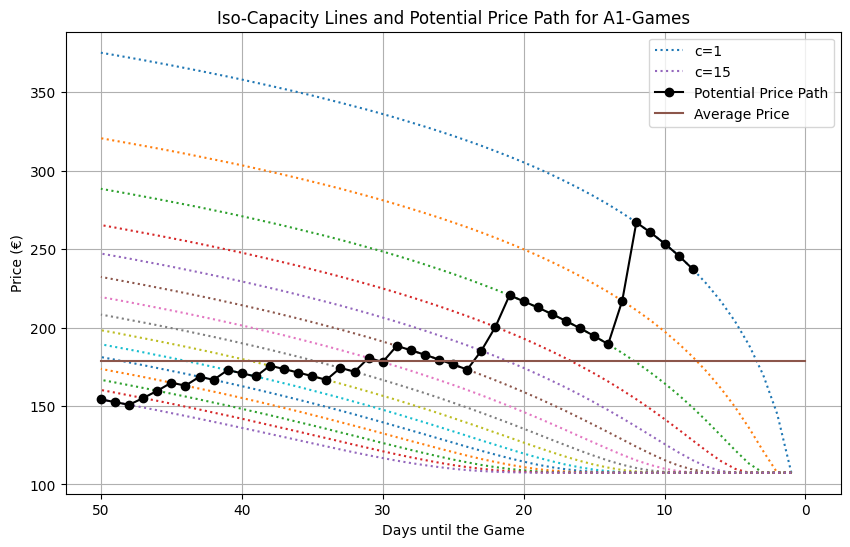

In [16]:

# Plot results
plt.figure(figsize=(10, 6))

# Plot iso-capacity lines
for c in range(1, C + 1):
    plt.plot(range(1,T+1), optimal_prices[c, 1:T + 1], linestyle='dotted', label=f'c={c}' if c in [1, 15] else "")

# Plot optimal price path
plt.plot(range(T,T-len(daily_prices),-1), daily_prices, marker='o', linestyle='-', label='Potential Price Path', color='black')

plt.plot([0,T], [avg_prices[-1],avg_prices[-1]], label= "Average Price" )
plt.xlabel("Days until the Game")
plt.ylabel("Price (€)")
plt.title("Iso-Capacity Lines and Potential Price Path for A1-Games")
plt.legend()
plt.gca().invert_xaxis()
plt.grid()
plt.show()


In [20]:
# Initialize structured data dictionary
simulated_data = {}

for category in demand_coeffs.keys():
    # Solve Bellman Equation for each category
    V, optimal_prices = bellman_equation(T, C, price_range, coeffs)
    
    # Run the simulation
    daily_prices, tickets_sold, avg_prices = simulate_sales(T, C, price_range, coeffs, optimal_prices)

    # Initialize category-specific data
    simulated_data[category] = {
        "V": V,
        "optimal_prices": optimal_prices,
        "revenues": {
            "dynamic": [],
            "fixed": [],
            "static": []
        },
        "tickets_sold": {
            "dynamic": [],
            "fixed": [],
            "static": []
        },
        "optimal_fixed_price": avg_prices[-1]+10,
        "current_ticket_price": final_df[final_df["Category"] == category]["AVG Price"].mean()
    }


In [21]:

# Monte Carlo Simulation Parameters
num_simulations = 1000  # Number of iterations

for _ in range(num_simulations):
    for category in demand_coeffs.keys():
        data = simulated_data[category]

        remaining_tickets = C
        revenue_dynamic = 0
        revenue_fixed = 0
        revenue_static = 0
        static_tickets_sold = 0
        fixed_tickets_sold = 0

        for t in range(T, 0, -1):
            # Dynamic pricing based on Bellman equation
            dynamic_price = data["optimal_prices"][remaining_tickets, t]
            wtp = np.random.rand()  # Random WTP probability

            if remaining_tickets > 0 and wtp < demand_function(dynamic_price, *coeffs):
                revenue_dynamic += dynamic_price
                remaining_tickets -= 1

            # Fixed pricing model with capacity constraint
            if fixed_tickets_sold < C and wtp < demand_function(data["optimal_fixed_price"], *coeffs):
                revenue_fixed += data["optimal_fixed_price"]
                fixed_tickets_sold += 1

            # Current ticket pricing model with capacity constraint
            if static_tickets_sold < C and wtp < demand_function(data["current_ticket_price"], *coeffs):
                revenue_static += data["current_ticket_price"]
                static_tickets_sold += 1

        # Store results
        data["revenues"]["dynamic"].append(revenue_dynamic)
        data["revenues"]["fixed"].append(revenue_fixed)
        data["revenues"]["static"].append(revenue_static)

        data["tickets_sold"]["dynamic"].append(C - remaining_tickets)
        data["tickets_sold"]["fixed"].append(fixed_tickets_sold)
        data["tickets_sold"]["static"].append(static_tickets_sold)

# Compute averages and prepare data for plotting
avg_revenues = {key: [] for key in ["dynamic", "fixed", "static"]}
avg_tickets_sold = {key: [] for key in ["dynamic", "fixed", "static"]}

for category in demand_coeffs.keys():
    data = simulated_data[category]

    for key in ["dynamic", "fixed", "static"]:
        avg_revenues[key].append(np.mean(data["revenues"][key]))
        avg_tickets_sold[key].append(np.mean(data["tickets_sold"][key]))



# Analysis of Ticket Pricing Strategies

## Introduction
In our analysis, we aim to maximize not only the revenue from ticket sales but also the number of attendees at an event. A full stadium generates additional revenue streams such as parking fees, beverage sales, and merchandise purchases. This makes ticket pricing a crucial factor in overall revenue optimization.

## Results from Simulation

### Simulated Revenues by Price and Seat Category
The first graph in our analysis compares the simulated revenues generated under three pricing models:
- **Current Ticket Price (Blue)**
- **Optimal Fixed Price (Orange)**
- **Dynamic Pricing (Green)**

From the graph, it is evident that the dynamic pricing model consistently outperforms both static pricing approaches. It maximizes revenue across all seat categories while ensuring competitive pricing strategies.

### Simulated Number of Sold Tickets by Price and Seat Category
The second graph highlights the number of tickets sold under each pricing model. Again, dynamic pricing proves to be the superior strategy. Not only does it generate higher revenue, but it also ensures that more seats are filled. A higher number of attendees translates to greater auxiliary revenue from services like parking and concessions.

## Scientific Validation
Our findings align with the results presented in the scientific study *"Designing a Dynamic Pricing Model for Bayern"*. The study emphasizes the advantages of dynamic pricing in optimizing both revenue and attendance. By adjusting ticket prices based on demand, market conditions, and purchasing behavior, venues can achieve superior financial outcomes.

## Conclusion
Dynamic pricing is a crucial strategy for maximizing event revenue while ensuring high attendance rates. It significantly outperforms static pricing models by balancing price elasticity with demand fluctuations. Adopting dynamic pricing not only leads to higher ticket revenues but also enhances the overall customer experience, benefiting both the venue and attendees.



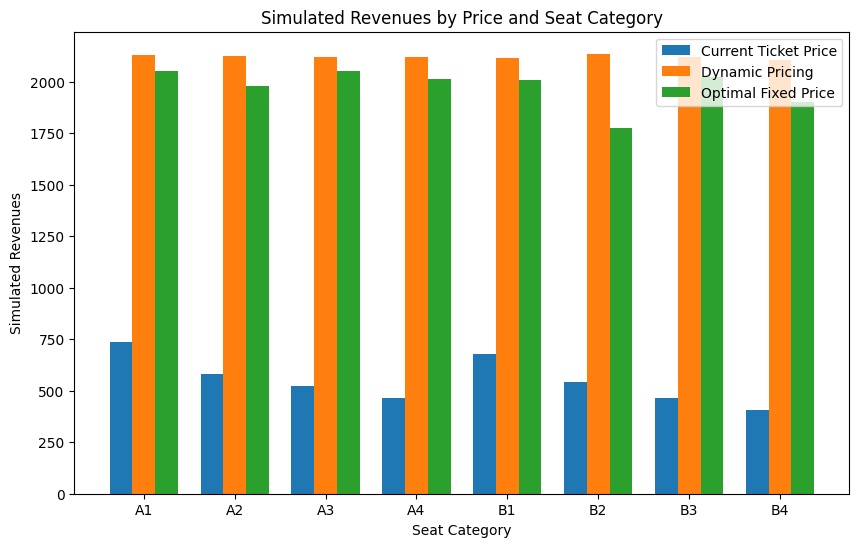

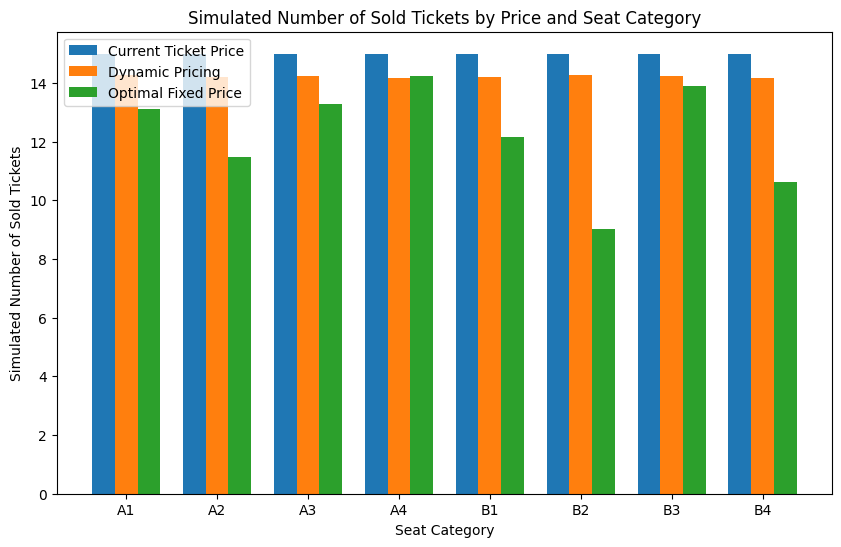

In [22]:
x = np.arange(len(demand_coeffs.keys()))
width = 0.25

# Plot 1: Simulated Revenues
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, avg_revenues["static"], width, label="Current Ticket Price")
ax.bar(x, avg_revenues["dynamic"], width, label="Dynamic Pricing")
ax.bar(x + width, avg_revenues["fixed"], width, label="Optimal Fixed Price")


ax.set_ylabel("Simulated Revenues")
ax.set_xlabel("Seat Category")
ax.set_title("Simulated Revenues by Price and Seat Category")
ax.set_xticks(x)
ax.set_xticklabels(demand_coeffs.keys())
ax.legend()

plt.show()

# Plot 2: Simulated Number of Sold Tickets
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, avg_tickets_sold["static"], width, label="Current Ticket Price")
ax.bar(x, avg_tickets_sold["dynamic"], width, label="Dynamic Pricing")
ax.bar(x + width, avg_tickets_sold["fixed"], width, label="Optimal Fixed Price")


ax.set_ylabel("Simulated Number of Sold Tickets")
ax.set_xlabel("Seat Category")
ax.set_title("Simulated Number of Sold Tickets by Price and Seat Category")
ax.set_xticks(x)
ax.set_xticklabels(demand_coeffs.keys())
ax.legend()

plt.show()


# Conclusion
### Summary of Findings
- The analysis confirms that implementing a **dynamic pricing model** can increase club's ticket revenue while maintaining a high occupancy rate.
- The **Monte Carlo simulation** demonstrated a significant revenue boost compared to fixed pricing models.
- **Market demand analysis** showed that secondary market prices often exceed official ticket prices, indicating pricing inefficiencies.

### Future Improvements
- Implement additional variables such as **weather conditions, team performance, and fan behavior** to enhance the model.
- Extend the study to other football clubs and leagues for a broader validation.
- Consider real-time demand fluctuations for a more adaptive pricing model.

This study highlights the potential of dynamic pricing in sports ticketing and provides a strong case for its implementation.
